In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from alp import plot_tools as pt
from alp import beams
from alp import models
from alp import exp
from alp.exp_dicts import EXPERIMENTS

# Fitting Pythia8 events to phenomenological parameterization

In [3]:
alp = models.ALP(0.5, 1e7)

NUMI_files = "pythia8_events/numi_120GeV.pkl"
SPS_files = "pythia8_events/sps_400GeV.pkl"
LHC_files = "pythia8_events/lhc_13.6TeV.pkl"

NUMI      = exp.Experiment(NUMI_files, exp_dic=EXPERIMENTS['ICARUS'], alp=alp, savemem=False)
SPS        = exp.Experiment(SPS_files, exp_dic=EXPERIMENTS['CHARM'], alp=alp, savemem=False)
LHC  = exp.Experiment(LHC_files, exp_dic=EXPERIMENTS['FASER'], alp=alp, savemem=False)

In [4]:
NUMI_taus_plus = NUMI.p4_taus[NUMI.df_taus['pid'] == +15]
SPS_taus_plus = SPS.p4_taus[SPS.df_taus['pid'] == +15]
LHC_taus_plus = LHC.p4_taus[LHC.df_taus['pid'] == +15]
NUMI_taus_minus = NUMI.p4_taus[NUMI.df_taus['pid'] == -15]
SPS_taus_minus = SPS.p4_taus[SPS.df_taus['pid'] == -15]
LHC_taus_minus = LHC.p4_taus[LHC.df_taus['pid'] == -15]

NUMI_weights_plus = NUMI.df_taus['weights'][NUMI.df_taus['pid'] == +15]
SPS_weights_plus = SPS.df_taus['weights'][SPS.df_taus['pid'] == +15]
LHC_weights_plus = LHC.df_taus['weights'][LHC.df_taus['pid'] == +15]
NUMI_weights_minus = NUMI.df_taus['weights'][NUMI.df_taus['pid'] == -15]
SPS_weights_minus = SPS.df_taus['weights'][SPS.df_taus['pid'] == -15]
LHC_weights_minus = LHC.df_taus['weights'][LHC.df_taus['pid'] == -15]

# Fitting Pythia8 distributions to analytic functions

In [5]:
best_fits = {}

## Fit $x_F$

In [8]:
from scipy.optimize import curve_fit

def fit_function_xF(xF, r1, a_1, a_2, r2, n1, n2, r3=1, a_3=1, n3=1):
    pdf = r1*np.exp(-a_1*abs(xF)**n1) + r2*np.exp(-a_2 * abs(xF)**n2) #+ r3*np.exp(-a_3 * abs(xF)**n3)
    norm = (np.sum(pdf[:-1]*np.diff(xF)))
    return pdf / norm

p_names = ['r_1', 'a_1', 'a_2', 'r_2', 'n_1', 'n_2']
def find_best_fit_for_xF(xf, weights=None, xmin=0, xmax=1, bins=200):
    weights = weights / weights.sum()
    hist, bin_edges = np.histogram(xf, bins=bins, range=(xmin, xmax), weights=weights, density=False)

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    dx_F = np.diff(bin_edges)
    hist /= dx_F
    norm = np.sum(hist*abs(dx_F))
    hist /= norm

    sumw2, _ = np.histogram(xf, bins=bin_edges, range=(xmin, xmax), weights=weights**2, density=False)
    sumw2 /= dx_F**2
    err = np.sqrt(sumw2) / norm

    if abs(xf).mean() >0.1:
        r_1 =   222.26
        a_1 =   213.85
        a_2 =   1765.57
        r_2 =   2191.59
        n_1 =   0.65
        n_2 =   4.61
    else:
        r_1=10
        a_1 = 21.57
        a_2 = 31.87
        r_2 = 152100.10
        n_1 = 1.89
        n_2 = 0.48
    
    hist[-1] = 0
    err[err <= 0 ] = 0.2
    # err[-] = 1e-8

    popt, pcov = curve_fit(fit_function_xF, bin_centers[hist>0], hist[hist>0], 
                           p0=[r_1, a_1, a_2, r_2, n_1, n_2], 
                           bounds=(len(p_names)*[0], 
                                   len(p_names)*[np.inf]), 
                            sigma=err[hist>0], 
                            absolute_sigma=True)
    return popt

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_23976/187598477.py:47: RuntimeWarning: divide by zero encountered in divide
  residuals = (hist - best_fit_curve) / hist
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_23976/187598477.py:49: RuntimeWarning: invalid value encountered in divide
  ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')


Fit parameters for NuMI tau-:
r_1 =   5112.29
a_1 =   18.32
a_2 =   119.43
r_2 =   82.01
n_1 =   2.03
n_2 =   6.87
Fit parameters for SPS tau-:
r_1 =   3810.67
a_1 =   16.70
a_2 =   2254.07
r_2 =   137.60
n_1 =   1.80
n_2 =   4.77
Fit parameters for LHC tau-:
r_1 =   351.77
a_1 =   17.10
a_2 =   26.02
r_2 =   126552.23
n_1 =   0.78
n_2 =   0.34


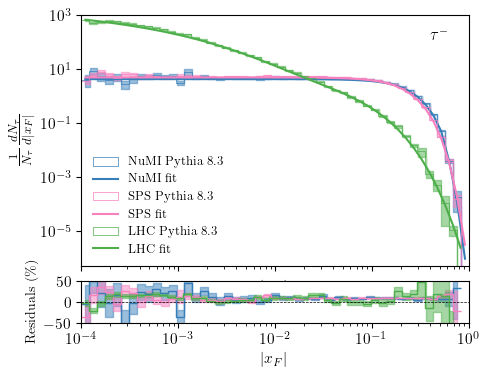

In [9]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 1, height_ratios=[3, 0.5], hspace=0.1)
ax = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax)
ax.loglog()

xf_numi = beams.get_xF(NUMI_taus_minus, 120)
xf_sps = beams.get_xF(SPS_taus_minus, 400)
xf_lhc = beams.get_xF(LHC_taus_minus, 13_600/2, CoM=True)

NUMI_weights = NUMI_weights_minus
SPS_weights = SPS_weights_minus
LHC_weights = LHC_weights_minus

BINS = 50
xmin = 1e-4
for x, weights, color, name, xmax in zip([xf_numi, xf_sps, xf_lhc], [NUMI_weights, SPS_weights, LHC_weights], pt.CB_color_cycle[:3], ['NuMI', 'SPS', 'LHC'], [1, 1, 0.9]):
    x_F = np.geomspace(xmin, xmax, BINS)
    dx_F = np.diff(x_F)

    weights = weights/weights.sum()
    hist, bin_edges = np.histogram(x, bins=x_F, range=(xmin, xmax), weights=weights, density=False)
    
    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    hist /= dx_F
    norm = np.sum(dx_F*hist)
    hist = hist / norm  # Normalize the histogram

    sumw2, _ = np.histogram(x, bins=x_F, range=(xmin, xmax), weights=weights**2, density=False)
    sumw2 /= dx_F**2
    err = np.sqrt(sumw2) / norm
    

    _ = ax.hist(bin_centers, weights=hist, label=f'{name} Pythia 8.3', color=color, histtype='step', lw=0.5, bins=bin_edges)
    ax.fill_between(bin_centers, hist - err, hist + err, color=color, alpha=0.5, step='mid')

    try:
        best_fit_params = find_best_fit_for_xF(x, weights=weights, xmin=xmin, xmax=xmax, bins=x_F)
    except Exception as e:
        print(f"Unexpected error fitting {name}: {e}")
        continue

    best_fit_curve = fit_function_xF(bin_centers, *best_fit_params)
    _ = ax.plot(bin_centers, best_fit_curve, label=f'{name} fit', color=color)
    # Residuals
    residuals = (hist - best_fit_curve) / hist
    ax_res.hist(bin_centers, weights=residuals*100, bins=x_F, color=color, histtype='step', label=f'{name} residuals')
    ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')
    best_fits['tau_minus', name] = {}
    best_fits['tau_minus', name].update({p_name: p for p_name, p in zip(p_names, best_fit_params)})
    print(f'Fit parameters for {name} tau-:')
    for p_name, p in zip(p_names, best_fit_params):
        print(f'{p_name} =   {p:.2f}')
        
ax.legend(loc='lower left', fontsize=9, frameon=False, ncol=1)
# ax.loglog()
ax.set_ylim(0.5e-6, 1e3)
ax_res.set_ylim(-50, 50)
ax.set_xlabel(r'$|x_F|$')
ax.set_ylabel(r'$\frac{1}{N_\tau}\frac{dN_\tau}{d |x_F|}$ ', fontsize=13)
plt.setp(ax.get_xticklabels(), visible=False)

ax_res.axhline(0, color='k', lw=0.5, ls='--')
ax_res.set_ylabel('Residuals ($\%$)', fontsize=10)
ax_res.set_xlabel(r'$|x_F|$')
ax_res.set_xlim(xmin, 1)
ax.annotate(r'$\tau^-$', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=12, color='k')
fig.savefig('plots/xF_fit_minus.pdf', dpi = 300, bbox_inches='tight')

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_23976/2998318961.py:45: RuntimeWarning: divide by zero encountered in divide
  residuals = (hist - best_fit_curve) / hist
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_23976/2998318961.py:47: RuntimeWarning: invalid value encountered in divide
  ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')


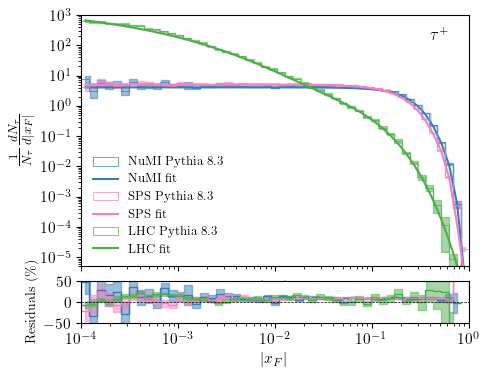

In [10]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 1, height_ratios=[3, 0.5], hspace=0.1)
ax = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax)

xf_numi = beams.get_xF(NUMI_taus_plus, 120)
xf_sps = beams.get_xF(SPS_taus_plus, 400)
xf_lhc = beams.get_xF(LHC_taus_plus, 13_600/2, CoM=True)

NUMI_weights = NUMI_weights_plus
SPS_weights = SPS_weights_plus
LHC_weights = LHC_weights_plus

BINS = 50
xmin = 1e-4
for x, weights, color, name, xmax in zip([xf_numi, xf_sps, xf_lhc], [NUMI_weights, SPS_weights, LHC_weights], pt.CB_color_cycle[:3], ['NuMI', 'SPS', 'LHC'], [1,1,0.9]):

    x_F = np.geomspace(xmin, xmax, BINS)
    dx_F = np.diff(x_F)

    weights = weights/weights.sum()
    hist, bin_edges = np.histogram(x, bins=x_F, range=(xmin, xmax), weights=weights, density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    hist /= dx_F
    norm = np.sum(dx_F*hist)
    hist = hist / norm  # Normalize the histogram

    sumw2, _ = np.histogram(x, bins=x_F, range=(xmin, xmax), weights=weights**2, density=False)
    sumw2 /= dx_F**2
    err = np.sqrt(sumw2) / norm
    

    _ = ax.hist(bin_centers, weights=hist, label=f'{name} Pythia 8.3', color=color, histtype='step', lw=0.5, bins=bin_edges)
    ax.fill_between(bin_centers, hist - err, hist + err, color=color, alpha=0.5, step='mid')

    try:
        best_fit_params = find_best_fit_for_xF(x, weights=weights, xmin=xmin, xmax=xmax, bins=x_F)
    except ValueError as e:
        print(f"Error fitting {name}: {e}")
        continue

    best_fit_curve = fit_function_xF(bin_centers, *best_fit_params)
    _ = ax.plot(bin_centers, best_fit_curve, label=f'{name} fit', color=color)
    # Residuals
    residuals = (hist - best_fit_curve) / hist
    ax_res.hist(bin_centers, weights=residuals*100, bins=x_F, color=color, histtype='step', label=f'{name} residuals')
    ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')
    
    best_fits['tau_plus', name] = {}
    best_fits['tau_plus', name].update({p_name: p for p_name, p in zip(p_names, best_fit_params)})

ax.legend(loc='lower left', fontsize=9, frameon=False, ncol=1)
ax.loglog()
ax.set_ylim(0.5e-5, 1e3)
ax_res.set_ylim(-50, 50)
ax.set_xlabel(r'$|x_F|$')
ax.set_ylabel(r'$\frac{1}{N_\tau}\frac{dN_\tau}{d |x_F|}$ ', fontsize=13)
plt.setp(ax.get_xticklabels(), visible=False)

ax_res.axhline(0, color='k', lw=0.5, ls='--')
ax_res.set_ylabel('Residuals ($\%$)', fontsize=10)
ax_res.set_xlabel(r'$|x_F|$')
ax_res.set_xlim(xmin, 1)
ax.annotate(r'$\tau^+$', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=12, color='k')
fig.savefig('plots/xF_fit_plus.pdf', dpi = 300, bbox_inches='tight')

## Fit in $p_T$

In [11]:
from scipy.stats import gamma

def fit_function_pT(p_T, g1, m1, mu1, lambda1, g2, m2, mu2, lambda2, g3, m3, mu3, lambda3):
    pdf = g1*gamma.pdf(p_T**m1, a=mu1, scale=lambda1) + g2*gamma.pdf(p_T**m2, a=mu2, scale=lambda2) + g3*gamma.pdf(p_T**m3, a=mu3, scale=lambda3)
    return pdf/np.sum(pdf[:-1]*np.diff(p_T))

p_names = ['g_1', 'm_1', 'mu_1', 'lambda_1', 'g_2', 'm_2', 'mu_2', 'lambda_2','g_3', 'm_3', 'mu_3', 'lambda_3']

def find_best_fit_for_pT(pT, weights=None, xmin=0, xmax=50, bins=100):
    weights = weights / weights.sum()
    hist, bin_edges = np.histogram(pT, bins=bins, range=(xmin, xmax), weights=weights, density=False)
    dpT = np.diff(bin_edges)
    hist /= dpT
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mask = hist > 0
    norm = np.sum(hist * dpT)
    hist /= norm  # Normalize the histogram

    sumw2, _ = np.histogram(pT, bins=bin_edges, range=(xmin, xmax), weights=weights**2, density=False)
    sumw2 /= dpT**2
    err = np.sqrt(sumw2) / norm
    
    if pT.max() > 10:
        g_1 =   29.40
        m_1 =   0.88
        mu_1 =   2.69
        lambda_1 =   0.68
        g_2 =   3.76
        m_2 =   0.61
        mu_2 =   2.42
        lambda_2 =   0.60
        g_3 =   0.23
        m_3 =   1.04
        mu_3 =   60.50
        lambda_3 =   0.12
    else:
        g_1 =   2632.30
        m_1 =   1.71
        mu_1 =   1.66
        lambda_1 =   0.93
        g_2 =   0.57
        m_2 =   1.00
        mu_2 =   89.18
        lambda_2 =   84.40
        g_3 =   0.57
        m_3 =   1.00
        mu_3 =   89.18
        lambda_3 =   84.40
    err[err <= 0] = 1e-8
    popt, pcov = curve_fit(fit_function_pT, bin_centers[mask], hist[mask], 
                           p0=[g_1, m_1, mu_1, lambda_1, g_2, m_2, mu_2, lambda_2, g_3, m_3, mu_3, lambda_3], 
                           bounds=(12*[0], 12*[np.inf]), sigma=err[mask], absolute_sigma=True)
    return popt


/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_23976/1428441619.py:48: RuntimeWarning: divide by zero encountered in divide
  residuals = (hist - best_fit_curve) / hist
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_23976/1428441619.py:50: RuntimeWarning: invalid value encountered in divide
  ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')


Fit parameters for NuMI tau-:
g_1 =   84411.01
m_1 =   1.90
mu_1 =   1.47
lambda_1 =   1.22
g_2 =   0.57
m_2 =   1.00
mu_2 =   89.18
lambda_2 =   84.40
g_3 =   0.57
m_3 =   1.00
mu_3 =   89.18
lambda_3 =   84.40
Fit parameters for SPS tau-:
g_1 =   9496674.67
m_1 =   1.51
mu_1 =   1.67
lambda_1 =   0.99
g_2 =   0.57
m_2 =   1.00
mu_2 =   89.18
lambda_2 =   84.40
g_3 =   0.57
m_3 =   1.00
mu_3 =   89.18
lambda_3 =   84.40
Fit parameters for LHC tau-:
g_1 =   22.30
m_1 =   0.85
mu_1 =   2.84
lambda_1 =   0.63
g_2 =   3.26
m_2 =   0.59
mu_2 =   2.55
lambda_2 =   0.53
g_3 =   4.63
m_3 =   2.17
mu_3 =   99.91
lambda_3 =   0.66


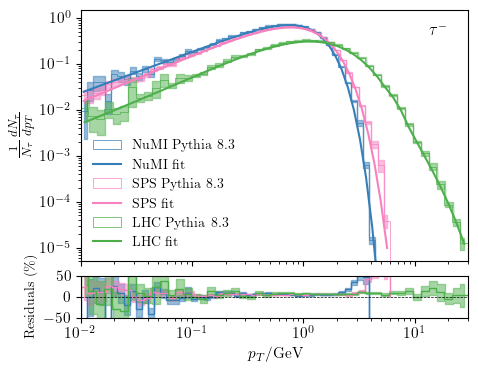

In [12]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 1, height_ratios=[3, 0.5], hspace=0.1)
ax = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax)


pT_numi = NUMI_taus_minus.pt
pT_sps = SPS_taus_minus.pt
pT_lhc = LHC_taus_minus.pt

NUMI_weights = NUMI_weights_minus
SPS_weights = SPS_weights_minus
LHC_weights = LHC_weights_minus

BINS = 50
xmin = 1e-2

for x, weights, color, name, xmax in zip([pT_numi, pT_sps, pT_lhc], [NUMI_weights, SPS_weights, LHC_weights], pt.CB_color_cycle[:3], ['NuMI', 'SPS', 'LHC'], [5,6,30]):

    pT = np.geomspace(xmin, xmax, BINS)
    dpT = np.diff(pT)
    weights = weights/weights.sum()

    try:
        best_fit_params = find_best_fit_for_pT(x, weights=weights, xmin=xmin, xmax=xmax, bins=pT)
    except RuntimeError as e:
        print(f"Error fitting {name}: {e}")
        continue
    hist, bin_edges = np.histogram(x, bins=pT, range=(xmin, xmax), weights=weights, density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    hist /= dpT
    norm = np.sum(hist * dpT)
    hist = hist / norm  # Normalize the histogram

    sumw2, _ = np.histogram(x, bins=pT, range=(0, xmax), weights=weights**2, density=False)
    sumw2 /= dpT**2
    err = np.sqrt(sumw2) / norm

    _ = ax.hist(bin_centers, weights=hist, label=f'{name} Pythia 8.3', color=color, histtype='step', lw=0.5, bins=bin_edges)
    ax.fill_between(bin_centers, hist - err, hist + err, color=color, alpha=0.5, step='mid')

    
    best_fit_curve = fit_function_pT(bin_centers, *best_fit_params)
    _ = ax.plot(bin_centers, best_fit_curve, label=f'{name} fit', color=color)
    # best_fit_curve_2 = fit_function_pT(bin_centers, *best_fit_params[:3],0,1,1,1)
    # _ = ax.plot(bin_centers, best_fit_curve_2, label=f'{name} fit', color=color)
    # Residuals
    residuals = (hist - best_fit_curve) / hist
    ax_res.hist(bin_centers, weights=residuals*100, bins=pT, color=color, histtype='step', label=f'{name} residuals')
    ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')
    print(f'Fit parameters for {name} tau-:')
    for p_name, p in zip(p_names, best_fit_params):
        print(f'{p_name} =   {p:.2f}')
    best_fits['tau_minus', name].update({p_name: p for p_name, p in zip(p_names, best_fit_params)})


ax.legend(loc='lower left', fontsize=10, frameon=False)
ax.loglog()
# ax.semilogy()
ax.set_xlim(xmin, xmax)
ax.set_ylim(5e-6, 1.5)
ax_res.set_ylim(-50, 50)
ax.set_ylabel(r'$\frac{1}{N_\tau}\frac{dN_\tau}{d p_T}$ ', fontsize=13)
plt.setp(ax.get_xticklabels(), visible=False)

ax_res.axhline(0, color='k', lw=0.5, ls='--')
ax_res.set_ylabel('Residuals ($\%$)', fontsize=10)
ax_res.set_xlabel(r'$p_T$/GeV')
ax_res.set_xlim(xmin, xmax)

ax.annotate(r'$\tau^-$', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=12, color='k')
fig.savefig('plots/pT_fit_minus.pdf', dpi = 300, bbox_inches='tight')

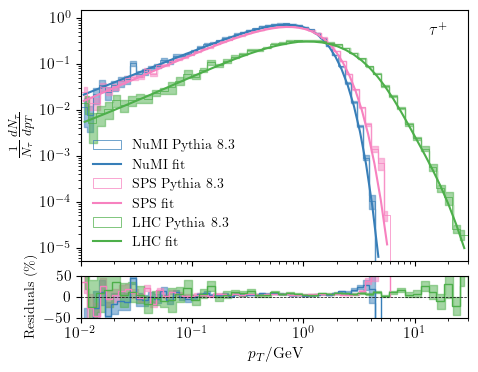

In [13]:
fig = plt.figure(figsize=(5, 4))
gs = GridSpec(2, 1, height_ratios=[3, 0.5], hspace=0.1)
ax = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax)


pT_numi = NUMI_taus_plus.pt
pT_sps = SPS_taus_plus.pt
pT_lhc = LHC_taus_plus.pt

NUMI_weights = NUMI_weights_plus
SPS_weights = SPS_weights_plus
LHC_weights = LHC_weights_plus

BINS = 50
xmin = 1e-2

for x, weights, color, name, xmax in zip([pT_numi, pT_sps, pT_lhc], [NUMI_weights, SPS_weights, LHC_weights], pt.CB_color_cycle[:3], ['NuMI', 'SPS', 'LHC'], [5,6,30]):

    pT = np.geomspace(xmin, xmax, BINS)
    dpT = np.diff(pT)
    weights = weights/weights.sum()

    try:
        best_fit_params = find_best_fit_for_pT(x, weights=weights, xmin=xmin, xmax=xmax, bins=pT)
    except RuntimeError as e:
        print(f"Error fitting {name}: {e}")
        continue
    hist, bin_edges = np.histogram(x, bins=pT, range=(xmin, xmax), weights=weights, density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    hist /= dpT
    norm = np.sum(hist * dpT)
    hist = hist / norm  # Normalize the histogram

    sumw2, _ = np.histogram(x, bins=pT, range=(0, xmax), weights=weights**2, density=False)
    sumw2 /= dpT**2
    err = np.sqrt(sumw2) / norm

    _ = ax.hist(bin_centers, weights=hist, label=f'{name} Pythia 8.3', color=color, histtype='step', lw=0.5, bins=bin_edges)
    ax.fill_between(bin_centers, hist - err, hist + err, color=color, alpha=0.5, step='mid')

    
    best_fit_curve = fit_function_pT(bin_centers, *best_fit_params)
    _ = ax.plot(bin_centers, best_fit_curve, label=f'{name} fit', color=color)
    # best_fit_curve_2 = fit_function_pT(bin_centers, *best_fit_params[:3],0,1,1,1)
    # _ = ax.plot(bin_centers, best_fit_curve_2, label=f'{name} fit', color=color)
    # Residuals
    residuals = (hist - best_fit_curve) / hist
    ax_res.hist(bin_centers, weights=residuals*100, bins=pT, color=color, histtype='step', label=f'{name} residuals')
    ax_res.fill_between(bin_centers, (residuals - err/hist)*100, 100*(residuals + err/hist), color=color, alpha=0.5, step='mid')
    
    # Best fit parameters
    best_fits['tau_plus', name].update({p_name: p for p_name, p in zip(p_names, best_fit_params)})


ax.legend(loc='lower left', fontsize=10, frameon=False)
ax.loglog()
# ax.semilogy()
ax.set_xlim(xmin, xmax)
ax.set_ylim(5e-6, 1.5)
ax_res.set_ylim(-50, 50)
ax.set_ylabel(r'$\frac{1}{N_\tau}\frac{dN_\tau}{d p_T}$ ', fontsize=13)
plt.setp(ax.get_xticklabels(), visible=False)

ax_res.axhline(0, color='k', lw=0.5, ls='--')
ax_res.set_ylabel('Residuals ($\%$)', fontsize=10)
ax_res.set_xlabel(r'$p_T$/GeV')
ax_res.set_xlim(xmin, xmax)

ax.annotate(r'$\tau^+$', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=12, color='k')
fig.savefig('plots/pT_fit_plus.pdf', dpi = 300, bbox_inches='tight')

# Check generation of events following parameterization:

In [14]:
params_NuMI_plus = best_fits['tau_plus', 'NuMI']
params_SPS_plus = best_fits['tau_plus', 'SPS']
params_LHC_plus = best_fits['tau_plus', 'LHC']
params_NuMI_minus = best_fits['tau_minus', 'NuMI']
params_SPS_minus = best_fits['tau_minus', 'SPS']
params_LHC_minus = best_fits['tau_minus', 'LHC']

In [75]:
print('NuMI_plus', params_NuMI_plus)
print('SPS_plus', params_SPS_plus)
print('LHC_plus', params_LHC_plus)
print('NuMI_minus', params_NuMI_minus)
print('SPS_minus', params_SPS_minus)
print('LHC_minus', params_LHC_minus)

NuMI_plus {'r_1': np.float64(48.68727912585043), 'a_1': np.float64(16.94707220807977), 'a_2': np.float64(18.38683120168382), 'r_2': np.float64(3593.679883555706), 'n_1': np.float64(4.5585146656868964), 'n_2': np.float64(2.089522851536656), 'g_1': np.float64(2047052.3275345126), 'm_1': np.float64(1.6839948036271786), 'mu_1': np.float64(1.5775564478333188), 'lambda_1': np.float64(0.9643819708358564), 'g_2': np.float64(0.57), 'm_2': np.float64(1.0), 'mu_2': np.float64(89.18), 'lambda_2': np.float64(84.4), 'g_3': np.float64(0.57), 'm_3': np.float64(1.0), 'mu_3': np.float64(89.18), 'lambda_3': np.float64(84.4)}
SPS_plus {'r_1': np.float64(0.3388667768506215), 'a_1': np.float64(31519936.646864433), 'a_2': np.float64(17.508813432875083), 'r_2': np.float64(189.76730162774177), 'n_1': np.float64(35.98208424771674), 'n_2': np.float64(1.8067293373835929), 'g_1': np.float64(2869884.819970777), 'm_1': np.float64(1.4400754803944809), 'mu_1': np.float64(1.728932552539325), 'lambda_1': np.float64(0.87

In [69]:
n_events = 1_000_000
for name, Ebeam, pT_max, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [5, 6, 30],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    collider = Ebeam == 13_600/2
    taus_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider, pid=-15, as_dict=True, pT_max=pT_max)
    taus_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider, pid=15, as_dict=True, pT_max=pT_max)
    taus = {k: np.concatenate([taus_minus[k], taus_plus[k]]) for k in taus_minus.keys()}
    exp.save_events_to_pickle(taus, f"tau_events/df_{name}_{n_events}_custom_parametrization.pkl")

    # if name == 'NuMI':
    #     p0 = [EXPERIMENTS['NoVA']['x0'], EXPERIMENTS['NoVA']['y0'], EXPERIMENTS['NoVA']['L'], EXPERIMENTS['NoVA']['dX']]
    #     df_minus = beams.generate_taus_with_custom_method(params_minus, n_trials=10_000_000, p_beam=Ebeam, n_events=n_events, CoM=collider, pid=-15, as_dict=True, pT_max=pT_max, cone_force_acceptance=p0)
    #     df_plus = beams.generate_taus_with_custom_method(params_plus,  n_trials=10_000_000, p_beam=Ebeam, n_events=n_events, CoM=collider, pid=15, as_dict=True, pT_max=pT_max, cone_force_acceptance=p0)
    #     df = pd.concat([df_minus, df_plus])
    #     df.to_parquet(f"tau_events/df_{name}_{n_events}_custom_parametrization_NoVA.parquet")
    #     print(f"tau_events/df_{name}_{n_events}_custom_parametrization_NoVA.parquet")

        # p0 = [EXPERIMENTS['MicroBooNE']['x0'], EXPERIMENTS['Mi croBooNE']['y0'], EXPERIMENTS['MicroBooNE']['L'], EXPERIMENTS['MicroBooNE']['dX']]
        # df_minus = beams.generate_taus_with_custom_method(params_minus, n_trials=10_000_000, p_beam=Ebeam, n_events=n_events, CoM=collider, pid=-15, as_dict=True, pT_max=pT_max, cone_force_acceptance=p0)
        # df_plus = beams.generate_taus_with_custom_method(params_plus,  n_trials=10_000_000, p_beam=Ebeam, n_events=n_events, CoM=collider, pid=15, as_dict=True, pT_max=pT_max, cone_force_acceptance=p0)
        # df = pd.concat([df_minus, df_plus])
        # df.to_parquet(f"tau_events/df_{name}_{n_events}_custom_parametrization_MicroBooNE.parquet")
        # print(f"tau_events/df_{name}_{n_events}_custom_parametrization_MicroBooNE.parquet")


Generated 1000000 taus, efficiency: 1.0000
Generated 1000000 taus, efficiency: 1.0000
Generated 1000000 taus, efficiency: 1.0000
Generated 1000000 taus, efficiency: 1.0000
Generated 1000000 taus, efficiency: 1.0000
Generated 1000000 taus, efficiency: 1.0000


In [74]:
alp = models.ALP(0.1, 1e8)

n_events = 10_000_000

# SPS_files = f"tau_events/df_SPS_{n_events}_custom_parametrization.parquet"
# CHARM = exp.Experiment(SPS_files, exp_dic=EXPERIMENTS['CHARM'], alp=alp, duplicate_taus=1, savemem=False)

NOVA_files = f"tau_events/df_NuMI_{n_events}_custom_parametrization.pkl"
NOVA = exp.Experiment(NOVA_files, exp_dic=EXPERIMENTS['NoVA'], alp=alp, duplicate_taus=1, savemem=False)
exp.save_events_to_pickle(NOVA, f"tau_events/NOVA_custom_parametrization.pkl")

MicroBooNE_files = f"tau_events/df_NuMI_{n_events}_custom_parametrization.pkl"
MicroBooNE = exp.Experiment(MicroBooNE_files, exp_dic=EXPERIMENTS['MicroBooNE'], alp=alp, duplicate_taus=1, savemem=False)
exp.save_events_to_pickle(MicroBooNE, f"tau_events/MicroBooNE_custom_parametrization.pkl")

ICARUS_files = f"tau_events/df_NuMI_{n_events}_custom_parametrization.pkl"
ICARUS = exp.Experiment(ICARUS_files, exp_dic=EXPERIMENTS['ICARUS'], alp=alp, duplicate_taus=1, savemem=False)
exp.save_events_to_pickle(ICARUS, f"tau_events/ICARUS_custom_parametrization.pkl")

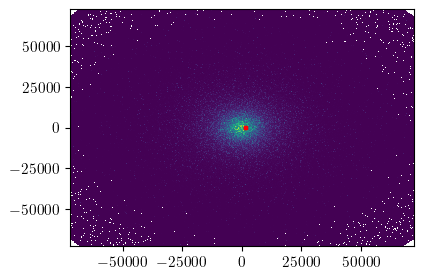

In [71]:
N=50
BINS=500

_=plt.hist2d(NOVA.x_alp, NOVA.y_alp, weights=NOVA.weights, bins=BINS, range=((-N*NOVA.x0, N*NOVA.x0), (-N*NOVA.x0, N*NOVA.x0)), density=True, cmap='viridis', cmin=1e-100),

vtau = NOVA.p4_taus.to_3D().unit()
x, y = vtau['x'] * NOVA.L, vtau['y'] * NOVA.L
# _=plt.hist2d(x, y, weights=NOVA.tau_weights, bins=BINS, range=((-N*NOVA.x0, N*NOVA.x0), (-N*NOVA.x0, N*NOVA.x0)), density=True, cmap='Blues', cmin=1e-100),
plt.scatter(NOVA.x0, NOVA.y0, marker='x', color='k', s=2)
plt.scatter(NOVA.x0+NOVA.dX/2, NOVA.y0+NOVA.dY/2, marker='s', color='red', s=2)
plt.scatter(NOVA.x0+NOVA.dX/2, NOVA.y0-NOVA.dY/2, marker='s', color='red', s=2)
plt.scatter(NOVA.x0-NOVA.dX/2, NOVA.y0-NOVA.dY/2, marker='s', color='red', s=2)
plt.scatter(NOVA.x0-NOVA.dX/2, NOVA.y0+NOVA.dY/2, marker='s', color='red', s=2)

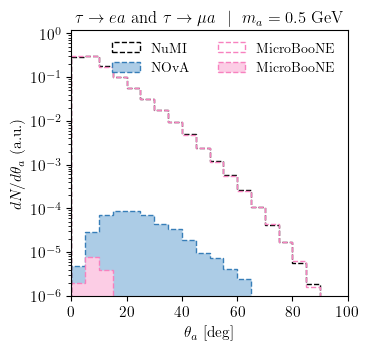

In [73]:
fig,ax = pt.std_fig(figsize=(3.5,3.5))

alp = models.ALP(0.5, 1e7)
xunits = 1#180 / np.pi
b = np.linspace(0, 100, 21)

#######################################################
# p4, w = MicroBooNE.get_alp_events(alp=alp)
# WNORM = np.sum(w)
# ax.hist(np.arccos(Cfv.get_cosTheta(p4))*xunits, bins=b, weights=w/WNORM, label='NuMI', histtype='stepfilled', edgecolor='black', facecolor='None', linestyle='-', density=False, zorder=1.9)


#######################################################
p4, w = NOVA.get_alp_events(alp=alp)
WNORM = np.sum(w)
ax.hist(p4['E']*xunits, bins=b, weights=w/WNORM, label='NuMI', histtype='stepfilled', edgecolor='black', facecolor='None', linestyle='--', density=False, zorder=1.9)

p4, w = NOVA.get_alps_in_acceptance(generate_events=True, alp=alp)
ax.hist(p4['E']*xunits, bins=b, weights=w/WNORM, label='NOvA', histtype='stepfilled', edgecolor=pt.CB_color_cycle[0], facecolor=pt.lighten_color(pt.CB_color_cycle[0], 0.4), linestyle='--', density=False, zorder=1.2)


#######################################################
p4, w = MicroBooNE.get_alp_events(alp=alp)
WNORM = np.sum(w)
ax.hist(p4['E']*xunits, bins=b, weights=w/WNORM, label='MicroBooNE', histtype='stepfilled', edgecolor=pt.CB_color_cycle[1], facecolor='None', linestyle='--', density=False, zorder=1.9)

p4, w = MicroBooNE.get_alps_in_acceptance(generate_events=True, alp=alp)
ax.hist(p4['E']*xunits, bins=b, weights=w/WNORM, label='MicroBooNE', histtype='stepfilled', edgecolor=pt.CB_color_cycle[1], facecolor=pt.lighten_color(pt.CB_color_cycle[1], 0.4), linestyle='--', density=False, zorder=1.2)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel(r'$\theta_{a}$ [deg]')
ax.set_ylabel(r'$dN/d \theta_a$ (a.u.)')

ax.set_xlim(0,b.max())
ax.set_ylim(1e-5, 1.2)
ax.set_yticks(np.geomspace(1e-6, 1, 7))
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.set_title(fr'$\tau \to e a$ and $\tau \to \mu a$ $\,\,\vert\,\,$ $m_a = {alp.m_a}$ GeV', fontsize=12)
fig.savefig('plots/check_acceptance_NuMI_alp_angular_spectrum.pdf', bbox_inches='tight')

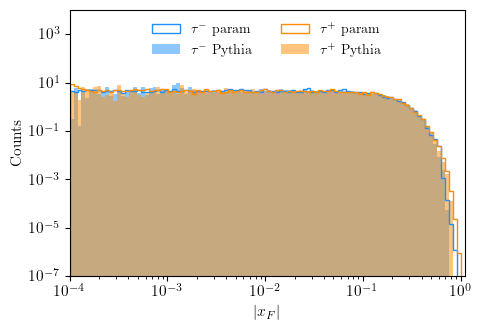

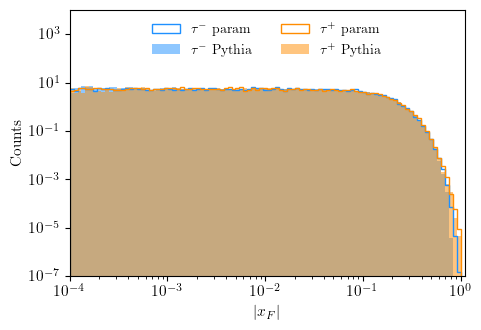

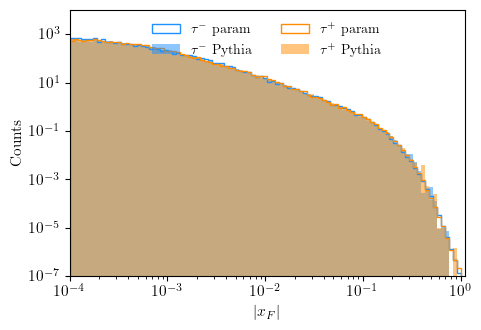

In [47]:
n_events = 100_000
bins = np.geomspace(1e-4, 1, 100)

for name, Ebeam, Pythia_taus_plus, Pythia_taus_minus, Pythia_weights_plus, Pythia_weights_minus, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [NUMI_taus_plus, SPS_taus_plus, LHC_taus_plus],
    [NUMI_taus_minus, SPS_taus_minus, LHC_taus_minus],
    [NUMI_weights_plus, SPS_weights_plus, LHC_weights_plus],
    [NUMI_weights_minus, SPS_weights_minus, LHC_weights_minus],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    fig, ax = pt.std_fig(figsize=(5, 3.5))
    
    collider = Ebeam == 13_600/2
    
    p4_minus, w_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(abs(beams.get_xF(p4_minus, Ebeam, CoM=collider)),weights=w_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
    ax.hist(abs(beams.get_xF(Pythia_taus_minus, Ebeam, CoM=collider)), weights=Pythia_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia', density=True, color='dodgerblue')

    p4_plus, w_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(abs(beams.get_xF(p4_plus, Ebeam, CoM=collider)), weights=w_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
    ax.hist(abs(beams.get_xF(Pythia_taus_plus, Ebeam, CoM=collider)), weights=Pythia_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia', density=True, color='darkorange')

    ax.set_xlabel(r'$|x_F|$')
    ax.set_ylabel(r'Counts')
    ax.legend(loc='upper center', ncol=2)
    ax.loglog()
    ax.set_xlim(1e-4, 1.1)
    ax.set_ylim(1e-7, 1e4)
    fig.savefig('plots/xF_check_{name}.pdf', dpi=300, bbox_inches='tight')

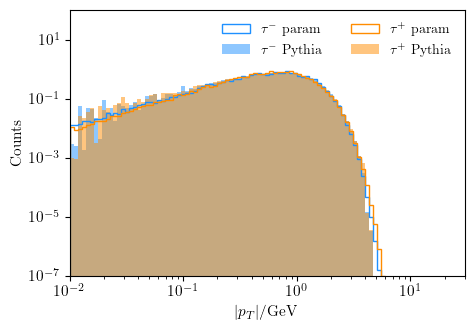

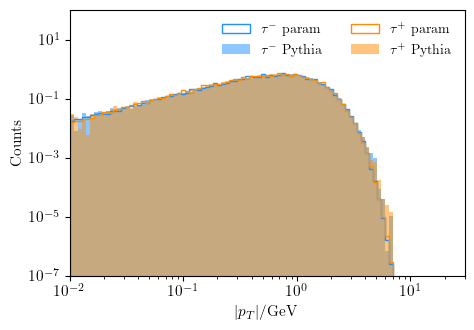

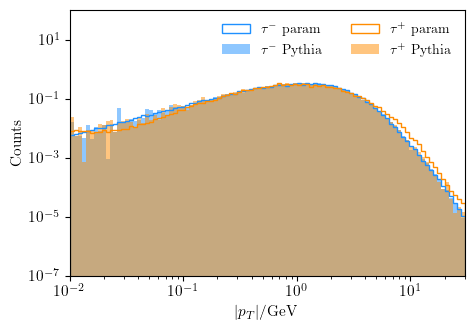

In [48]:
n_events = 100_000
bins = np.geomspace(1e-2, 30, 100)

for name, Ebeam, Pythia_taus_plus, Pythia_taus_minus, Pythia_weights_plus, Pythia_weights_minus, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [NUMI_taus_plus, SPS_taus_plus, LHC_taus_plus],
    [NUMI_taus_minus, SPS_taus_minus, LHC_taus_minus],
    [NUMI_weights_plus, SPS_weights_plus, LHC_weights_plus],
    [NUMI_weights_minus, SPS_weights_minus, LHC_weights_minus],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    fig, ax = pt.std_fig(figsize=(5, 3.5))
    
    collider = Ebeam == 13_600/2
    
    p4_minus, w_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(beams.get_pT(p4_minus),weights=w_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
    ax.hist(beams.get_pT(Pythia_taus_minus), weights=Pythia_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia', density=True, color='dodgerblue')

    p4_plus, w_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(beams.get_pT(p4_plus), weights=w_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
    ax.hist(beams.get_pT(Pythia_taus_plus), weights=Pythia_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia', density=True, color='darkorange')

    ax.set_xlabel(r'$|p_T|$/GeV')
    ax.set_ylabel(r'Counts')
    ax.legend(loc='upper right', ncol=2)
    ax.loglog()
    # ax.semilogy()
    ax.set_xlim(bins.min(), bins.max())
    ax.set_ylim(1e-7, 1e2)
    fig.savefig('plots/pT_check_{name}.pdf', dpi=300, bbox_inches='tight')

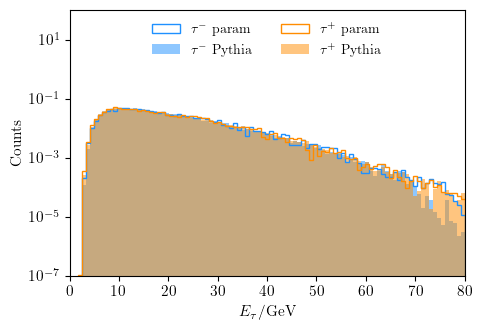

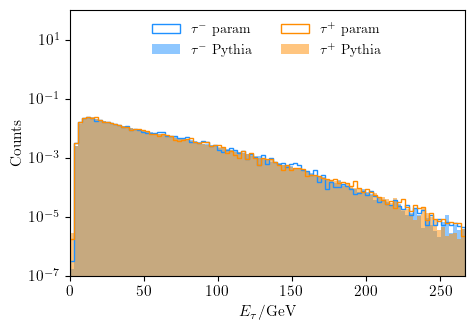

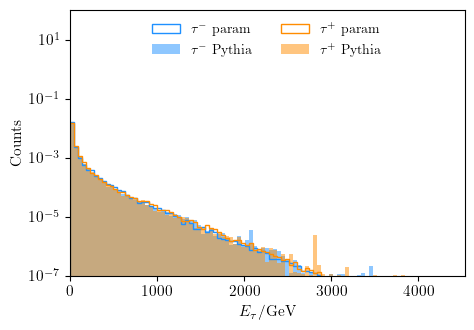

In [62]:
n_events = 100_000

for name, Ebeam, Pythia_taus_plus, Pythia_taus_minus, Pythia_weights_plus, Pythia_weights_minus, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [NUMI_taus_plus, SPS_taus_plus, LHC_taus_plus],
    [NUMI_taus_minus, SPS_taus_minus, LHC_taus_minus],
    [NUMI_weights_plus, SPS_weights_plus, LHC_weights_plus],
    [NUMI_weights_minus, SPS_weights_minus, LHC_weights_minus],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    fig, ax = pt.std_fig(figsize=(5, 3.5))
    bins = np.linspace(0, Ebeam/1.5, 100)

    collider = Ebeam == 13_600/2
    
    p4_minus, w_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(p4_minus[:,0],weights=w_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
    ax.hist(Pythia_taus_minus[:,0], weights=Pythia_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia', density=True, color='dodgerblue')

    p4_plus, w_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(p4_plus[:,0], weights=w_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
    ax.hist(Pythia_taus_plus[:,0], weights=Pythia_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia', density=True, color='darkorange')

    ax.set_xlabel(r'$E_\tau$/GeV')
    ax.set_ylabel(r'Counts')
    ax.legend(loc='upper center', ncol=2)
    ax.semilogy()
    ax.set_xlim(0,Ebeam/1.5)
    ax.set_ylim(1e-7, 1e2)
    fig.savefig(f'plots/Etau_check_{name}.pdf', dpi=300, bbox_inches='tight')

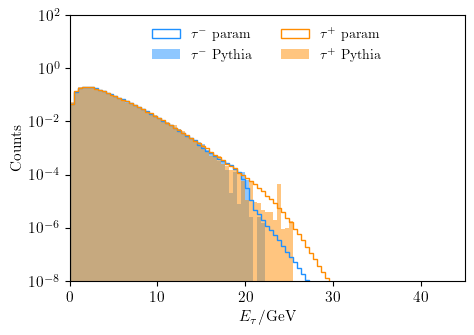

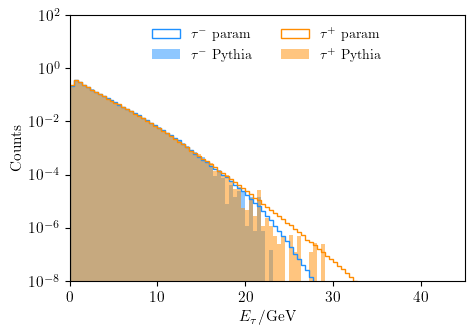

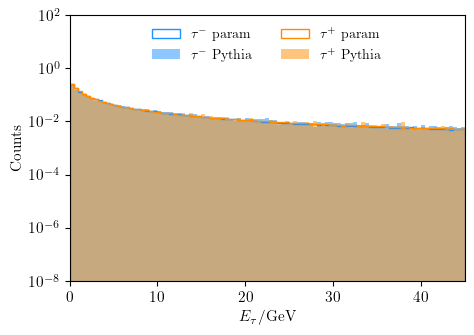

In [61]:
n_events = 10_000_000

for name, Ebeam, Pythia_taus_plus, Pythia_taus_minus, Pythia_weights_plus, Pythia_weights_minus, params_plus, params_minus in zip(
    ['NuMI', 'SPS', 'LHC'],
    [120, 400, 13_600/2],
    [NUMI_taus_plus, SPS_taus_plus, LHC_taus_plus],
    [NUMI_taus_minus, SPS_taus_minus, LHC_taus_minus],
    [NUMI_weights_plus, SPS_weights_plus, LHC_weights_plus],
    [NUMI_weights_minus, SPS_weights_minus, LHC_weights_minus],
    [params_NuMI_plus, params_SPS_plus, params_LHC_plus],
    [params_NuMI_minus, params_SPS_minus, params_LHC_minus],
):
    fig, ax = pt.std_fig(figsize=(5, 3.5))
    bins = np.linspace(0, 45, 100)

    collider = name == 'LHC'
    
    p4_minus, w_minus = beams.generate_taus_with_custom_method(params_minus, p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(np.arccos(Cfv.get_cosTheta(p4_minus))*180/np.pi,weights=w_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
    ax.hist(np.arccos(Cfv.get_cosTheta(Pythia_taus_minus))*180/np.pi, weights=Pythia_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia', density=True, color='dodgerblue')

    p4_plus, w_plus = beams.generate_taus_with_custom_method(params_plus,  p_beam=Ebeam, n_events=n_events, CoM=collider)
    ax.hist(np.arccos(Cfv.get_cosTheta(p4_plus))*180/np.pi, weights=w_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
    ax.hist(np.arccos(Cfv.get_cosTheta(Pythia_taus_plus))*180/np.pi, weights=Pythia_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia', density=True, color='darkorange')

    ax.set_xlabel(r'$E_\tau$/GeV')
    ax.set_ylabel(r'Counts')
    ax.legend(loc='upper center', ncol=2)
    ax.semilogy()
    ax.set_xlim(0,bins.max())
    ax.set_ylim(1e-8, 1e2)
    fig.savefig(f'plots/Etau_check_{name}.pdf', dpi=300, bbox_inches='tight')

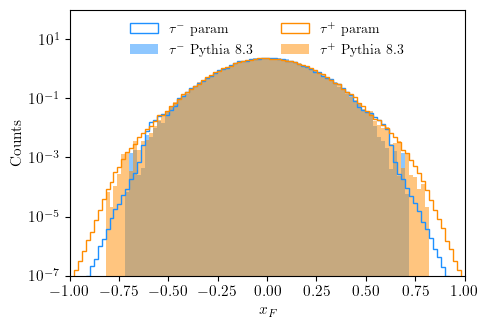

In [60]:
fig, ax = pt.std_fig(figsize=(5, 3.5))

bins = np.linspace(-1, 1, 100)

p4_numi_minus, w_numi_minus = beams.generate_taus_with_custom_method(params_NuMI_minus, p_beam=120, n_events=NUMI_weights_minus.size)
ax.hist(beams.get_xF(p4_numi_minus, 120),weights=w_numi_minus, bins=bins, alpha=1, histtype='step', label=r'$\tau^-$ param', density=True, color='dodgerblue')
ax.hist(beams.get_xF(NUMI_taus_minus, 120), weights=NUMI_weights_minus, bins=bins, alpha=0.5, label=r'$\tau^-$ Pythia 8.3', density=True, color='dodgerblue')

p4_numi_plus, w_numi_plus = beams.generate_taus_with_custom_method(params_NuMI_plus,  p_beam=120, n_events=NUMI_weights_plus.size)
ax.hist(beams.get_xF(p4_numi_plus, 120), weights=w_numi_plus, bins=bins, alpha=1, histtype='step', label=r'$\tau^+$ param', density=True, color='darkorange')
ax.hist(beams.get_xF(NUMI_taus_plus, 120), weights=NUMI_weights_plus, bins=bins, alpha=0.5, histtype='stepfilled', label=r'$\tau^+$ Pythia 8.3', density=True, color='darkorange')

ax.set_xlabel(r'$x_F$')
ax.set_ylabel(r'Counts')
ax.legend(loc='upper center', ncol=2)
ax.semilogy()
ax.set_xlim(-1, 1)
ax.set_ylim(1e-7, 1e2)
fig.savefig(f'plots/xF_NuMI_check.pdf', dpi=300, bbox_inches='tight')

## Check that xF and pT are approximately uncorrelated

/opt/homebrew/Caskroom/miniforge/base/envs/darknews/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


[]

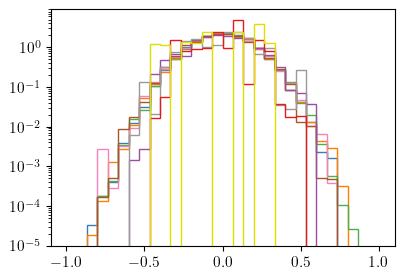

In [51]:
pT_numi = np.sqrt(beams.get_pTSQR(NUMI_taus_plus))
xf_numi = beams.get_xF(NUMI_taus_plus, 120)

xcuts = np.linspace(0, 5, 11)
for xmin, xmax in zip(xcuts[:-1], xcuts[1:]):
    mask = (pT_numi >= xmin) & (pT_numi < xmax)
    plt.hist(xf_numi[mask], weights=NUMI_weights_plus[mask], bins=30, range=(-1,1), histtype='step', label=f'NuMI {xmin:.2f} < pT < {xmax:.2f}', density=True)
plt.semilogy()

[]

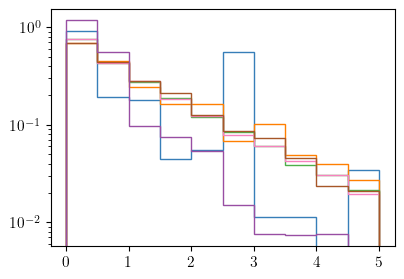

In [52]:
xf_numi = beams.get_xF(NUMI_taus_plus, 120)
pTsqr_numi = beams.get_pTSQR(NUMI_taus_plus)

xcuts = np.linspace(-1, 1, 7)
for xmin, xmax in zip(xcuts[:-1], xcuts[1:]):
    mask = (xf_numi >= xmin) & (xf_numi < xmax)
    plt.hist(pTsqr_numi[mask], weights=NUMI_weights_plus[mask], bins=10, range=(0, 5), histtype='step', label=f'NuMI {xmin:.2f} < xF < {xmax:.2f}', density=True)
plt.semilogy()

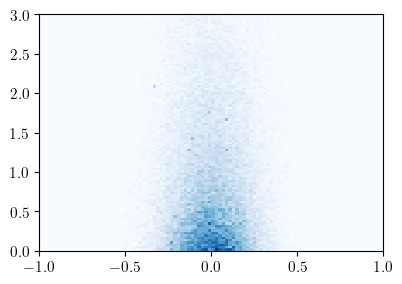

In [58]:
_=plt.hist2d(xf_numi, pTsqr_numi, weights=NUMI_weights_plus, bins=100, range=[(-1, 1), (0, 3)], cmap='Blues')